Use the code below to load the two accompanying files.

coordinate_data.pickle contains the coordinates of 4 points in 3D space (coord_X), and the volume of the solid formed by using those 4 points as vertices (coord_y).
NOTE: coord_X has already been centered about the origin, and then reshaped into (N, 12) so it is ready to use in the "k hidden layers" class.

distance_data.pickle contains the 6 pairwise distances of 4 points in 3D space (dist_X), and the volume of the solid formed by using those 4 points as vertices (dist_y).

In [123]:
import pickle
def pickle_load(filename):
    with open(filename, 'rb') as f:
        contents = pickle.load(f)
        return contents
    return contents

# the network will throw errors without the reshaping of y
coord_X, coord_y = pickle_load('coordinate_data.pickle')
coord_y = np.reshape(coord_y, (-1, 1))
dist_X, dist_y = pickle_load('distance_data.pickle')
dist_y = np.reshape(dist_y, (-1, 1))

Instructions:

As always, rename this file to include your first and last name before submitting.

Split up the data into a training set and validation set (use 1% of the data for validation)

Use the k_hidden_layer class that Frank posted to train two neural networks: one that can predict the volume of the solid based on the coordinate data, and another that can predict the volume based on the pairwise distances.

The current setup of k_hidden_layer is using the crossentropy loss function, which works well for classification (like on MNIST), but does not make sense for for a regression problem like this one (you should make sure you understand why this is by looking at how crossentropy is formulated).  You will need to rewrite that part of the code to implement the mean squared error (MSE) loss function defined below.  There are three parts you need to edit: the gradient calculation, the loss, and you need to print the loss instead of accuracy.

$$ \text{MSE Loss:} L = \frac{1}{n} \sum_{i=1}^{n} (y_{i, pred} - y_{i, true})^2 \hspace{1 cm} \text{(where n is the batch size)}$$

NOTE: To get the training to work well you will need to also look at the distribution of y (see the code below).  One of the most important data preprocessing steps is making sure your labels are spread out evenly (Why?).  The ideal is a uniform distribution, but a normal distribution is often good enough.  To get y to have a (roughly) uniform distribution you can use a one-to-one function like log, or nth root on y for training (or a combination of one-to-one functions), then apply the inverse of the function on your predictions when you want to make a prediction.  Print out the histogram of your transformed data using the code below (you should be able to get it to look like a normal distribution without too much work).

Make sure to play around with the structure of your network (the number of hidden layers, and number of nodes in each layer), and the learning rate.  Try to get the validation loss to decrease steadily.

Answer the following questions (either in Markdown, or in commented code): Which type of data was better for predicting the volume? Would you expect that data type to be better? Why or why not?

I have copied the working k_hidden_layer class to this notebook below.

Please send any questions to dfurman@uidaho.edu, or use office hours for help.

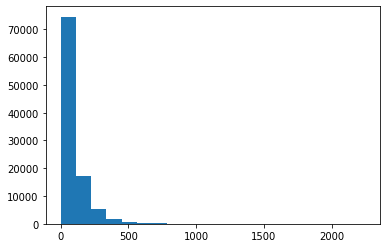

In [124]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
plt.hist(coord_y, bins=20)
plt.show()

In [ ]:
class k_hidden_layer(object):
    def __init__(self, sizes):
        self.num_layers = len(sizes)
        self.Bs = [np.zeros((1,size)) for size in sizes[1:]]
        self.Ws = [np.random.randn(m,n)/np.sqrt(m)
                   for m,n in zip(sizes[:-1], sizes[1:])]

    def loss(self, X, y=None, reg=0.0):
        Out = np.dot(X,self.Ws[0])+self.Bs[0]
        Outs=[Out]
        for W, B in zip(self.Ws[1:], self.Bs[1:]):
            Out = np.dot(np.maximum(0,Out), W)+B
            Outs.append(Out)
        if y is None:
            return Outs
        
        P=np.zeros_like(Out)
        N=X.shape[0]
        P[range(N),y]=1       
        M=np.max(Out,axis=1,keepdims=True)
        Q = np.exp(Out-M)/np.sum(np.exp(Out-M), axis=1,keepdims=True)
        L = -np.mean(np.log(Q[range(N),y]+1e-300)) # Add eps to avoid overflow
        for W in self.Ws:
            L += reg*np.sum(W**2)
            
        dWs = [np.zeros_like(W) for W in self.Ws]
        dBs = [np.zeros_like(B) for B in self.Bs]
        dOuts = [np.zeros_like(Out) for Out in Outs]
        dOuts[-1] = (Q-P)/N
        for i in range(2,self.num_layers):
            dOuts[-i] = (Outs[-i]>0)*np.dot(dOuts[-i+1],self.Ws[-i+1].T)
        dBs[0] = np.sum(dOuts[0], axis=0, keepdims=True)
        dWs[0] = np.dot(X.T,dOuts[0])+2*reg*self.Ws[0]
        for layer in range(1,self.num_layers-1):    
            dBs[layer] = np.sum(dOuts[layer], axis=0, keepdims=True)
            dWs[layer] = np.dot(np.maximum(0,Outs[layer-1]).T,dOuts[layer])
            dWs[layer] += 2*reg*self.Ws[layer]
        return L, dBs, dWs
    
    def train(self, X_train, y_train, X_val=None, y_val=None,
              learning_rate=1e-3, learning_rate_decay=0.99,
              reg=5e-3, epochs=5, batch_size=60, verbose=False):
        loss_history = []
        train_acc_history = []
        val_acc_history = []
        N = X_train.shape[0]
        iteration=0
        for epoch in range(epochs):
            perm=np.arange(N)
            np.random.shuffle(perm)
            X_batches = [X_train[perm[k:k+batch_size]] 
                         for k in range(0, N, batch_size)]
            y_batches = [y_train[perm[k:k+batch_size]] 
                         for k in range(0, N, batch_size)]
            for X,y in zip(X_batches, y_batches):
                L, dBs, dWs = self.loss(X, y ,reg)
                self.Ws = [W - learning_rate*dW for W,dW in zip(self.Ws, dWs)]
                self.Bs = [B - learning_rate*dB for B,dB in zip(self.Bs, dBs)]
                
                if iteration % 100 == 0:  
                    loss_history.append(L)   
                    y_pred = self.predict(X)
                    train_acc = np.mean(y_pred==y) 
                    train_acc_history.append(train_acc)                               
                    if X_val is not None:
                        y_val_pred = self.predict(X_val)
                        val_acc = np.mean(y_val_pred==y_val) 
                        val_acc_history.append(val_acc)
                    if verbose:
                        if X_val is not None:
                            print('iteration %d: loss %f, train_acc: %f, val_acc: %f' 
                                  % (iteration, L, train_acc, val_acc))
                        else:
                            print('iteration %d: loss %f, train_acc: %f' 
                                  % (iteration, L, train_acc))
                iteration+=1
            if X_val is not None:
                print('Epoch ', epoch+1, 'validation accuracy: ', val_acc)
            else:
                print('Epoch ', epoch+1, 'completed.')
            learning_rate*=learning_rate_decay
         
        return {'loss_history': loss_history,
                'train_acc_history': train_acc_history,
                'val_acc_history': val_acc_history}
               
    def predict(self, X):
        y_pred=np.argmax(self.loss(X)[-1],axis=1)
        return y_pred